In [1]:
# Plot differences in performace for different cache ways compared to 2-way
# How do we show 1024?

# Maybe start with 256-2 as "base", then relative number for each bar.
# So 256-2, 256-4, 512-2, 512-4, 1024-2, 1024-4

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
from matplotlib.offsetbox import AnchoredText
import pandas as pd
import numpy as np
from Color import *
from operator import truediv, sub
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter

# Matplotlib font configuration
from MatplotlibFonts import *

# Helpers
from BrokenPlot import *

# Change the font size
rcParams.update({"font.size": 13})

In [4]:
%reload_ext autoreload
from BenchmarkConfiguration import *
from Color import *

In [5]:
RESULT_DIR='../benchmarks/logs'

In [6]:
Benchmarks = [
    'coremark',
    'picojpeg',
    'aes',
    'crc',
    'dijkstra',
    'sha',
    'adpcm',
    'quicksort',
    'towers'
]

BaseConfigurations = [
    'nacho_naive',
    'nacho_pw',
    'nacho_stcont',
    'nacho_pw_st',
    'nacho_pw_stcont',
    'nacho_clank',
    'prowl',
    'clank',
    'plain_c'
]

CacheConfigurations = [
    '256-2',
    '256-4',
    '512-2',
    '512-4',
    '1024-2',
    '1024-4'
]

In [7]:
# Load all the results into a dictionary

def loadResult(Results, benchmark, config, cache, postfix='-0-0-O3-final'):
    if cache == '0-0':
        filename = RESULT_DIR + '/' + benchmark + '-uninstrumented-run-' + config + postfix
    else:
        filename = RESULT_DIR + '/' + benchmark + '-uninstrumented-run-' + config + '-' + cache + postfix
    
    #print(filename)
    if config not in Results[benchmark]:
        Results[benchmark][config] = {}
    
    # Add the results
    Results[benchmark][config][cache] = dict(pd.read_csv(filename, delimiter=":", header = None).values)

Results = {}

for benchmark in Benchmarks:
    Results[benchmark] = {}

    # Load Nacho results
    nacho_caches = [
        '256-2',
        '256-4',
        '512-2',
        '512-4',
        '1024-2',
        '1024-4'
    ]
    for cache in nacho_caches:
        loadResult(Results, benchmark, 'nacho_pw_stcont', cache)
        
    loadResult(Results, benchmark, 'plain_c', '0-0', '-O3-final')


#Results

In [8]:
# Benchmark plots with execution time
# Plot each benchmark, each config, two cache configs (256, 512)

PlotBenchmarks = Benchmarks
PlotConfigurations = BaseConfigurations

EntryToPlot='cycles'

def getPlotData(PlotData, benchmark, config, cache):
    key = cache
    if key not in PlotData[benchmark]:
        PlotData[benchmark][key] = {}
        
    PlotData[benchmark][cache] = Results[benchmark][config][cache][EntryToPlot]

PlotData = {}
for benchmark in PlotBenchmarks:
    PlotData[benchmark] = {}
    for cache in CacheConfigurations:
        getPlotData(PlotData, benchmark, 'nacho_pw_stcont', cache)
        
    # plain0c
    getPlotData(PlotData, benchmark, 'plain_c', '0-0')
    
    
#PlotData
PlotDataDF = pd.DataFrame.from_dict(PlotData)

In [9]:
NormPlotDataDF = PlotDataDF / PlotDataDF.T['0-0']
NormPlotDataDF = NormPlotDataDF.drop('0-0')
NormPlotDataDF = NormPlotDataDF.T
NormPlotDataDF = NormPlotDataDF.rename(BenchmarkNameMap)
NormPlotDataDF

,256-2,256-4,512-2,512-4,1024-2,1024-4
CoreMark,1.818602,1.790583,1.115071,1.102345,1.046593,1.020922
picojpeg,3.136882,1.574456,2.759422,1.316839,1.185487,1.181993
Tiny AES,1.257591,1.247403,1.098676,1.071242,0.931321,0.930949
CRC,1.477919,1.440972,1.274252,1.226460,1.247875,1.199072
Dijkstra,2.041934,2.024074,1.928581,1.922431,1.562980,1.467164
SHA,1.732630,1.757448,1.465907,1.327717,1.167207,1.167864
adpcm,1.139350,1.117154,1.078384,1.090496,1.061831,1.061795
quicksort,1.678230,1.577622,1.388361,1.335437,1.211999,1.201091
towers,5.258123,1.401364,4.407711,1.021172,1.000991,1.000000


In [10]:
%reload_ext autoreload
from BenchmarkConfiguration import *
from Color import *

# Colors
ColorMap = {
    '256-2': Color['darkblue'],
    '256-4': Color['darkblue'],
    '512-2': Color['blue'],
    '512-4': Color['blue'],
    '1024-2': Color['lightblue'],
    '1024-4': Color['lightblue'],
}

way_2_hatch = ''
way_4_hatch = '\\\\\\'
HatchMap = {
    '256-2': way_2_hatch,
    '256-4': way_4_hatch,
    '512-2': way_2_hatch,
    '512-4': way_4_hatch,
    '1024-2': way_2_hatch,
    '1024-4': way_4_hatch,
}

color_list = []
hatch_list = []
for cfg in NormPlotDataDF:  
    color_list += [ColorMap[cfg]]
    hatch_list += [HatchMap[cfg]]
    
print('Colors:', color_list)
print('Hatches:', hatch_list)

Colors: ['#464B75', '#464B75', '#0077BB', '#0077BB', '#00A6D6', '#00A6D6']
Hatches: ['', '\\\\\\', '', '\\\\\\', '', '\\\\\\']


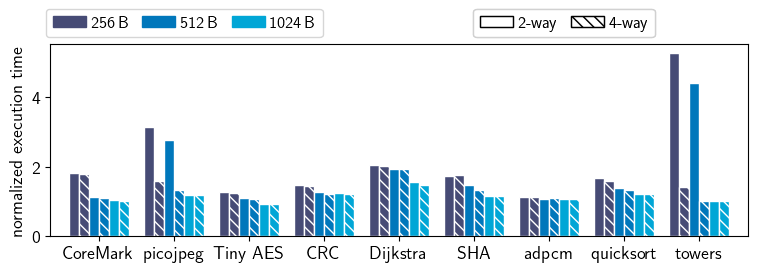

In [11]:

# Execution time plot
fig = plt.figure(figsize=(9, 2.5))
ax = fig.add_subplot(111)

NormPlotDataDF.plot(kind='bar', ax=ax, legend=None, width=0.8, color=color_list, edgecolor='white', linewidth=1)

applyHatches(Benchmarks, hatch_list, ax)

#
# Add custom legend (manual way)
#
 
# Config legend
configs = ['256\,B', '512\,B', '1024\,B']
config_colors = [ColorMap['256-2'], ColorMap['512-2'], ColorMap['1024-2']]

handles = []
for idx, l in enumerate(configs):
    handles.append(Patch(label=l, color=config_colors[idx]))
legend_configs = plt.legend(handles=handles, loc='lower left', ncol=4, bbox_to_anchor = (-0.018, 0.99), 
                            fancybox=True, fontsize=12, columnspacing=0.8, handletextpad=0.3);
ax.add_artist(legend_configs)

# Cache legends
ways = ['2-way', '4-way']
ways_hatches = [way_2_hatch, way_4_hatch]

# Config legend

handles = []
for idx, l in enumerate(ways):
    handles.append(Patch(label=l, hatch=ways_hatches[idx], facecolor='none', edgecolor='black'))
way_configs = plt.legend(handles=handles, loc='lower left', ncol=2, bbox_to_anchor = (0.595, 0.99), 
                           fancybox=True, fontsize=12, columnspacing=0.8, handletextpad=0.3);
ax.add_artist(way_configs)

# Plotting
ax.set_ylabel("normalized execution time")

plt.subplots_adjust(hspace=0.15)

plt.xticks(rotation=0)
#plt.tight_layout()
plt.show()

In [12]:
# Save the figure
ax.get_figure().savefig('plots/benchmark-exploration.pdf', bbox_inches='tight')